# TimeSeries

Bulan 1:
Rata-rata Kelembapan Udara: 85.062
Rata-rata Suhu Udara: 27
Rata-rata Curah Hujan: 371.82



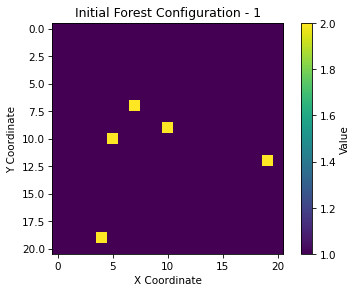

Bulan 2:
Rata-rata Kelembapan Udara: 83.76
Rata-rata Suhu Udara: 27.36
Rata-rata Curah Hujan: 322.78



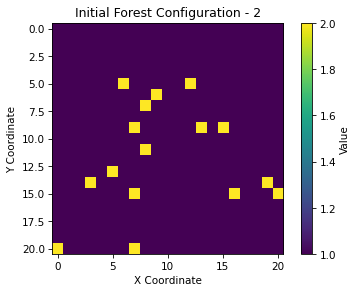

Bulan 3:
Rata-rata Kelembapan Udara: 84.72
Rata-rata Suhu Udara: 27.22
Rata-rata Curah Hujan: 367.14



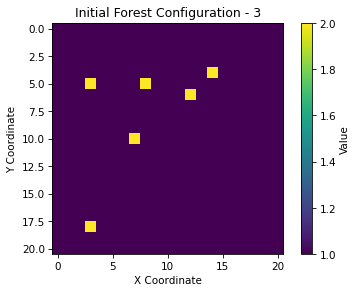

Bulan 4:
Rata-rata Kelembapan Udara: 84.2
Rata-rata Suhu Udara: 27.7
Rata-rata Curah Hujan: 303.86



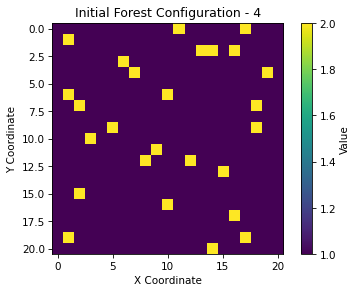

Bulan 5:
Rata-rata Kelembapan Udara: 83.96
Rata-rata Suhu Udara: 28.1
Rata-rata Curah Hujan: 215.54



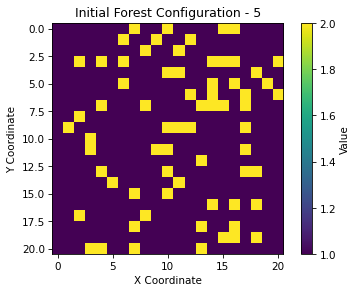

Bulan 6:
Rata-rata Kelembapan Udara: 83.92
Rata-rata Suhu Udara: 27.54
Rata-rata Curah Hujan: 148.16



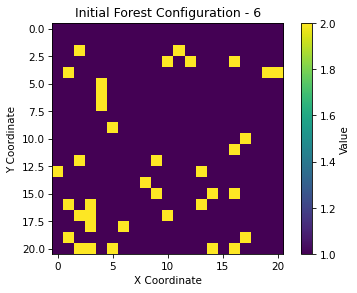

Bulan 7:
Rata-rata Kelembapan Udara: 82.2
Rata-rata Suhu Udara: 27.28
Rata-rata Curah Hujan: 85.94



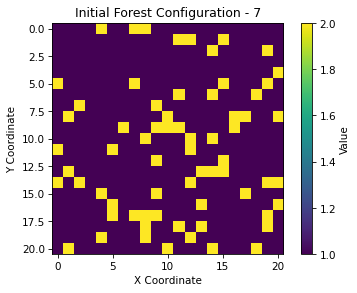

Bulan 8:
Rata-rata Kelembapan Udara: 80.58
Rata-rata Suhu Udara: 27.32
Rata-rata Curah Hujan: 103.86



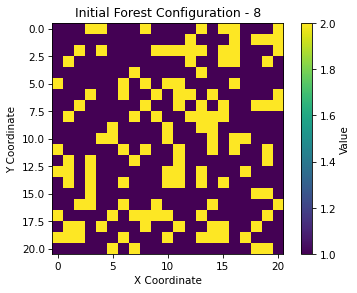

Bulan 9:
Rata-rata Kelembapan Udara: 80.4
Rata-rata Suhu Udara: 27.58
Rata-rata Curah Hujan: 113.9



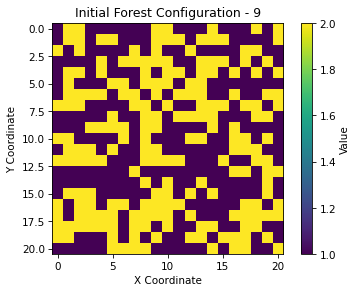

Bulan 10:
Rata-rata Kelembapan Udara: 81.14
Rata-rata Suhu Udara: 27.8
Rata-rata Curah Hujan: 193.3



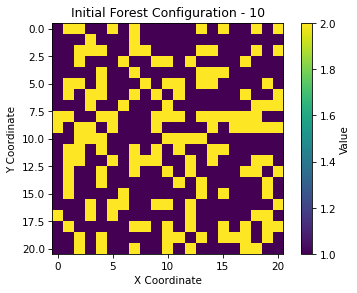

Bulan 11:
Rata-rata Kelembapan Udara: 83.72
Rata-rata Suhu Udara: 27.48
Rata-rata Curah Hujan: 278.7



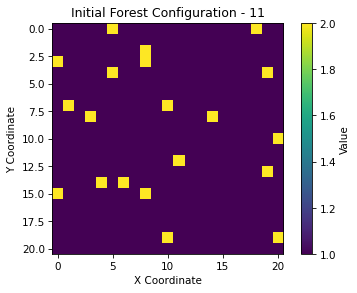

Bulan 12:
Rata-rata Kelembapan Udara: 84.66
Rata-rata Suhu Udara: 27.18
Rata-rata Curah Hujan: 274.7



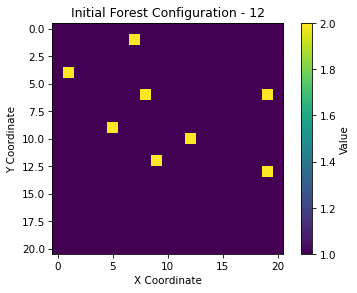

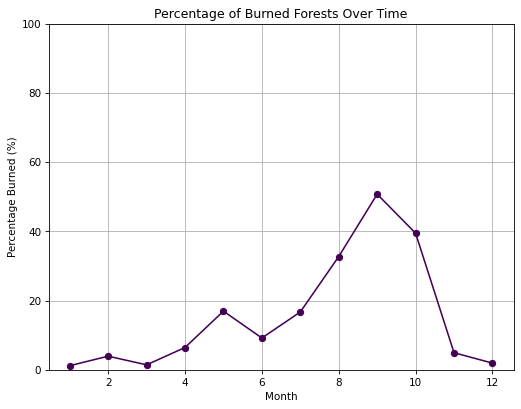

In [13]:
from modsim import *
import matplotlib.pylab as plt
import numpy as np
import random

value_tree = 1
value_titik_kebakaran = 2
jumlah_bulan = 12
empty = 0
state = State(jumlah_pohon_x=20, jumlah_pohon_y=20, jumlah_titik_kebakaran=5)

data_per_month = [
    # rata-rata kelembapan udara	rata-rata suhu udara	rata-rata curah hujan	rata-rata titik panas
    (85.062, 27, 371.82),   # Januari
    (83.76, 27.36, 322.78), # Februari
    (84.72, 27.22, 367.14), # Maret
    (84.2, 27.7, 303.86),   # April
    (83.96, 28.1, 215.54),  # Mei
    (83.92, 27.54, 148.16), # Juni
    (82.2, 27.28, 85.94),   # Juli
    (80.58, 27.32, 103.86), # Agustus
    (80.4, 27.58, 113.9),   # September
    (81.14, 27.8, 193.3),   # Oktober
    (83.72, 27.48, 278.7),  # November
    (84.66, 27.18, 274.7)   # Desember
]

system = System(
    kelembapan=data_per_month[0],
    suhu=data_per_month[1],
    curah_hujan=data_per_month[2]
)

min_kelembapan = 80.4       # September
max_kelembapan = 85.062     # Januari

min_suhu = 27               # Januari
max_suhu = 28.1             # Mei

min_curah_hujan = 85.94     # Juli
max_curah_hujan = 371.82    # Januari

def prob_burn_with_curah_hujan(curah_hujan):
    if curah_hujan <= min_curah_hujan:
        return 1.0  # Probability of fire occurrence is 1 when curah_hujan is less than or equal to min_curah_hujan
    elif curah_hujan >= max_curah_hujan:
        return 0.0  # Probability of fire occurrence is 0 when curah_hujan is greater than or equal to max_curah_hujan
    else:
        # Calculate the probability based on linear interpolation
        slope = -1 / (max_curah_hujan - min_curah_hujan)
        intercept = 1 - slope * min_curah_hujan
        return slope * curah_hujan + intercept
    
def prob_burn_with_avg_suhu(avg_suhu):
    if avg_suhu <= min_suhu:
        return 0.0  # Probability of fire occurrence is 0 when avg_suhu is less than or equal to min_suhu
    elif avg_suhu >= max_suhu:
        return 1.0  # Probability of fire occurrence is 1 when avg_suhu is greater than or equal to max_suhu
    else:
        # Calculate the probability based on linear interpolation
        slope = 1 / (max_suhu - min_suhu)
        intercept = 1 - slope * max_suhu
        return slope * avg_suhu + intercept
    
def prob_burn_with_kelembapan_udara(kelembapan_udara):
    if kelembapan_udara <= min_kelembapan:
        return 1.0  # Probability of fire occurrence is 1 when kelembapan_udara is less than or equal to min_kelembapan
    elif kelembapan_udara >= max_kelembapan:
        return 0.0  # Probability of fire occurrence is 0 when kelembapan_udara is greater than or equal to max_kelembapan
    else:
        # Calculate the probability based on linear interpolation
        slope = -1 / (max_kelembapan - min_kelembapan)
        intercept = 1 - slope * min_kelembapan
        return slope * kelembapan_udara + intercept
    
def prob_burn(curah_hujan, avg_suhu, kelembapan_udara):
    # Calculate probabilities for each parameter using interpolation functions
    prob_curah_hujan = prob_burn_with_curah_hujan(curah_hujan)
    prob_avg_suhu = prob_burn_with_avg_suhu(avg_suhu)
    prob_kelembapan_udara = prob_burn_with_kelembapan_udara(kelembapan_udara)
    
    # Calculate the overall probability of fire occurrence as the product of individual probabilities
    overall_prob = prob_curah_hujan * prob_avg_suhu * prob_kelembapan_udara
    # Return the calculated overall probability
    return overall_prob

def hutanAwal(month_index, state):
    hutan = np.zeros((state.jumlah_pohon_x + 1, state.jumlah_pohon_y + 1))

    # Randomly select positions for titik kebakaran (fire spots)
    titik_kebakaran_positions = random.sample(
        [
            (i, j)
            for i in range(1, state.jumlah_pohon_x + 1)
            for j in range(1, state.jumlah_pohon_y + 1)
        ],
        state.jumlah_titik_kebakaran
    )
    for pos in titik_kebakaran_positions:
        hutan[pos[0]][pos[1]] = value_titik_kebakaran
        
    for i in range(state.jumlah_pohon_x + 1):
        for j in range(state.jumlah_pohon_y + 1):
            if hutan[i][j] == 0:
                kelembapan_udara, avg_suhu, curah_hujan = data_per_month[month_index]
                prob = prob_burn(curah_hujan, avg_suhu, kelembapan_udara)
                random_value = random.random()
                if random_value < prob:
                    hutan[i][j] = value_titik_kebakaran
                else:
                    hutan[i][j] = value_tree
    return hutan

def count_burned_trees(hutan):
    return np.count_nonzero(hutan == value_titik_kebakaran)

def calculate_percentage_burned(hutan):
    total_trees = state.jumlah_pohon_x * state.jumlah_pohon_y
    burned_trees = count_burned_trees(hutan)
    return (burned_trees / total_trees) * 100

percentages_burned = []
months = [
    '1', '2', '3', '4', '5', '6',
    '7', '8', '9', '10', '11', '12'
]

results = TimeSeries()

for month_index, data in enumerate(data_per_month):
    month_name = months[month_index]

    print(f"Bulan {month_name}:")
    print(f"Rata-rata Kelembapan Udara: {data[0]}")
    print(f"Rata-rata Suhu Udara: {data[1]}")
    print(f"Rata-rata Curah Hujan: {data[2]}")
    print()

    a = hutanAwal(month_index, state)
    percentage_burned = calculate_percentage_burned(a)
    results[month_index + 1] = percentage_burned

    plt.imshow(a, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title(f'Initial Forest Configuration - {month_name}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

    percentage_burned = calculate_percentage_burned(a)
    percentages_burned.append(percentage_burned)

# Plotting the percentage of burned forests based on time (months)
plt.figure(figsize=(8, 6))
results.plot(marker='o', cmap='viridis')
plt.title('Percentage of Burned Forests Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage Burned (%)')
plt.ylim(0, 100)
plt.grid()
plt.show()

# SweepSeries

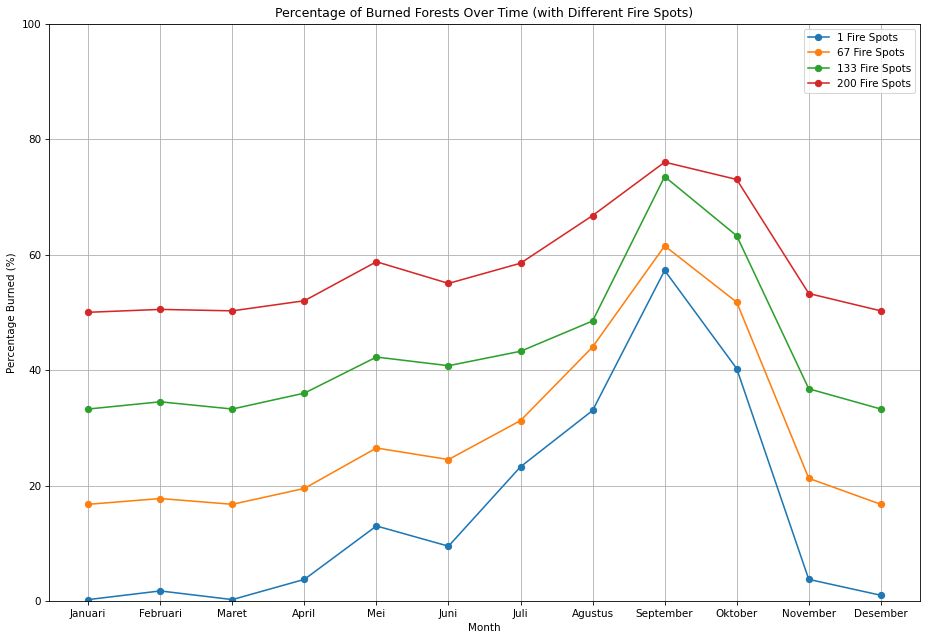

In [14]:
value_tree = 1
value_titik_kebakaran = 2
jumlah_titik_kebakaran_values = linspace(1, 200, 4)
sweep_results = SweepSeries()
jumlah_bulan = 12
empty = 0

def hutanAwal(state, jumlah_titik_kebakaran, month_index):
    hutan = np.zeros((state.jumlah_pohon_x + 1, state.jumlah_pohon_y + 1))
    titik_kebakaran_positions = random.sample(
        [(i, j) for i in range(1, state.jumlah_pohon_x + 1) for j in range(1, state.jumlah_pohon_y + 1)], jumlah_titik_kebakaran
    )
    for pos in titik_kebakaran_positions:
        hutan[pos[0]][pos[1]] = value_titik_kebakaran
        
    for i in range(state.jumlah_pohon_x + 1):
        for j in range(state.jumlah_pohon_y + 1):
            if hutan[i][j] == 0:
                kelembapan_udara, avg_suhu, curah_hujan = data_per_month[month_index]
                prob = prob_burn(curah_hujan, avg_suhu, kelembapan_udara)
                random_value = random.random()
                if random_value < prob:
                    hutan[i][j] = value_titik_kebakaran
                else:
                    hutan[i][j] = value_tree
    return hutan

def run_simulation(state, jumlah_titik_kebakaran):
    results = TimeSeries()
    for month_index, data in enumerate(data_per_month):
        a = hutanAwal(state, jumlah_titik_kebakaran, month_index)
        percentage_burned = calculate_percentage_burned(a)
        results[month_index + 1] = percentage_burned
    return results


def plot_sweepseries(sweep_results):
    plt.figure(figsize=(15, 10))
    for jumlah_titik_kebakaran in sweep_results.index:
        sweep_results[jumlah_titik_kebakaran].plot(label=f'{jumlah_titik_kebakaran} Fire Spots', marker='o')
    plt.title('Percentage of Burned Forests Over Time (with Different Fire Spots)')
    plt.xlabel('Month')
    plt.ylabel('Percentage Burned (%)')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid()
    month_indices = range(1, len(months) + 1)
    plt.xticks(month_indices, months)
    plt.show()

# Create the System object
system = System(
    kelembapan=data_per_month[0],
    suhu=data_per_month[1],
    curah_hujan=data_per_month[2]
)

# Create the State object
state = State(jumlah_pohon_x=20, jumlah_pohon_y=20, jumlah_titik_kebakaran=5)

# Run the simulation and sweep the number of fire spots
percentages_burned = []
months = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
          'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']

for jumlah_titik_kebakaran in jumlah_titik_kebakaran_values:
    results = run_simulation(state, int(jumlah_titik_kebakaran))
    sweep_results[int(jumlah_titik_kebakaran)] = results


# Plot the sweepseries
plot_sweepseries(sweep_results)